In [1]:
from google.colab import files
uploaded = files.upload()


Saving squares_7.tiff to squares_7.tiff


In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import pandas as pd
from PIL import Image
from numpy import asarray
from scipy.sparse import coo_matrix
from sklearn.feature_extraction import image
from sklearn.preprocessing import normalize

In [3]:
def compute_adj_deg_matrices(image_array):
  # Initialize the graph with the 4-neighbor graph
  graph = image.img_to_graph(image_array.astype(float))

  # As Intensities can have values between 0-255, 
  #we use the sigma value with 15% of 255
  sigma = 255*0.15
  graph.data = np.exp(-np.square(graph.data / sigma)/2) # This is called the Kernel Matrix

  # Now, let us compute the adjacency Matrix
  adjacency = graph.toarray()-np.diag(np.diag(graph.toarray()))

  # Compute the edges of the adjacency matrix
  edges = []
  for i in range(adjacency.shape[0]):
    for j in range(i,adjacency.shape[1]):
      if adjacency[i,j]!=0 and i!=j:
        edges.append((i,j))
  return adjacency, edges

In [10]:
def get_list_of_images():
    list_images = uploaded.keys()
    return list_images


def open_image(file_name):
  imag = Image.open(file_name) 
  image_array = np.asarray(imag)
  return image_array


def plot_segmentation_results(image_array, V_matrix):
  fig, axs = plt.subplots(1,1, figsize = (3.5,3.5), constrained_layout=True, sharey=True)
  # show the clusters 
  axs.matshow(V_matrix.reshape(image_array.shape), cmap=plt.get_cmap('gray'))
  axs.set_title('Brute Force', ha="center", va="center", color="k", fontsize=20, fontweight = 'medium')
  axs.set_xticks(np.arange(-0.5,4.5))
  axs.set_yticks(np.arange(-0.5,4.5))
  axs.set_xticklabels([])
  axs.set_yticklabels([])
  plt.show()


# Create the network or Graph using Nx library to compute the cut size
def create_network(adjacency_matrix, edges):
    # Identify working pixels
    number_of_pixels = adjacency_matrix.shape[0]

    # Populate a networkx graph with pixels as nodes.
    working_graph = nx.Graph()
    for node in range(number_of_pixels):
        working_graph.add_node(node)

    # Pair up all neighbors with random weights in working_graph.
    for pixel in edges:
        working_graph.add_edge(pixel[0], pixel[1], weight=adjacency_matrix[pixel[0], pixel[1]])
    return working_graph, number_of_pixels


# Compute the size of the cut given the segmentation list and the graph
def compute_cut_size(segmentation_list, graph):
    df = pd.Series(segmentation_list)
    one_qubits = set(df[df==1].index)
    S_partition = set()
    T_partition = set()
    for node in graph:
      if node in one_qubits:
        # If a one was measured add node to S partition.
        S_partition.add(node)
      else:
        # Otherwise a zero was measured so add to T partition.
        T_partition.add(node)

    norm_cut_nx = nx.normalized_cut_size(graph, S_partition, T_partition, weight='weight')
    return norm_cut_nx



def get_binary_segment(number, pixels):
  get_bin = lambda x, n: format(x, 'b').zfill(n)
  segment = []
  for bit in get_bin(number,pixels):
    segment.append(int(bit))
  return segment

In [11]:
def main():
  list_of_images = ['squares_7.tiff']#get_list_of_images()
  results = []
  num  = 0
  for image in list_of_images:
    # Open the image 
    image_array = open_image(image)
    
    # Compute the adjacency matrix and the edges
    adjacency_matrix, edges = compute_adj_deg_matrices(image_array)

    # Compute the cut size of the segmentation made
    nx_graph, pixels = create_network(adjacency_matrix, edges)
    
    minimum_cut = float(10000)
    min_seg = []
    for number in range(1,2**pixels-1):
      # compute and append results
      segment = get_binary_segment(number, pixels)
      norm_cut_nx = compute_cut_size(segment, nx_graph)
      
      # Choose the minimum cut 
      if norm_cut_nx < minimum_cut:
        minimum_cut = np.around(norm_cut_nx,6)
        min_seg = segment
    results.append([image, minimum_cut])
    plot_segmentation_results(image_array, np.array(min_seg))
  return results

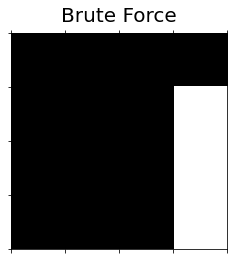

,0,1
0,squares_7.tiff,0.153272


In [12]:
import pandas as pd

results = main()
results_df = pd.DataFrame(results)
results_df.to_excel("Results_Brute_Force.xlsx") 
results_df

In [ ]:
results_df